# Football Tweet Classification Using Supervised Learning and NLP

## Introduction

Social media platforms like X (formerly Twitter) offer a wealth of data that reflects real-time public opinion, trends, and events. In this project, we focus on a dataset of X-posts (which we will refer to as tweets) originating from London and aim to classify whether or not a post relates to, firstly, a game involving Arsenal FC, and later, football in general.

Rather than relying on fully labeled data - which is often expensive and time-consuming to produce - we applied a weak supervision approach, using keyword matching to generate approximate labels. We then trained and evaluated multiple classification models on this noisy dataset, holding out a small manually labeled subset (referred to as the gold set) for validation.

This project demonstrates a full natural language processing (NLP) pipeline, from data cleaning and preprocessing to vectorisation, model training, and performance evaluation using metrics such as precision, recall, and F1 score. It also highlights common challenges in real-world text classification, including class imbalance and the ambiguity in human language.

## Importing Data

In [1]:
# Import the modules we are going to use

# General use
import pandas as pd
import numpy as np
from functools import reduce
import re

# ML general use
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

# sklearn ML models
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

# ML performance metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

# Visualisation
from matplotlib import pyplot as plt

In [2]:
# Import our json file and assign to a dataframe
london_tweets = pd.read_json("london.json", lines = True)

In [3]:
# Inspect our dataframe to familiarise ourselves with the data
print(len(london_tweets))
print(london_tweets.columns)

5341
Index(['created_at', 'id', 'id_str', 'text', 'display_text_range', 'source',
       'truncated', 'in_reply_to_status_id', 'in_reply_to_status_id_str',
       'in_reply_to_user_id', 'in_reply_to_user_id_str',
       'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place',
       'contributors', 'is_quote_status', 'extended_tweet', 'quote_count',
       'reply_count', 'retweet_count', 'favorite_count', 'entities',
       'favorited', 'retweeted', 'filter_level', 'lang', 'timestamp_ms',
       'possibly_sensitive', 'quoted_status_id', 'quoted_status_id_str',
       'quoted_status', 'quoted_status_permalink', 'extended_entities'],
      dtype='object')


Upon initial inspection, we have 5341 tweets in the `london_tweets` dataset. 

We will begin by inspecting the first tweet in the dataset.

In [4]:
# Preview the text in a few of our tweets
print("1) " + london_tweets.loc[0]["text"])
print("2) " + london_tweets.loc[70]["text"])
print("3) " + london_tweets.loc[400]["text"])

1) @bbclaurak i agree Laura but the Party you seem to support so strongly is slowly doing the same thing . . . and usi… https://t.co/tsRsVBozIR
2) What a pen by Adan
3) @petshopboys @RoyalOperaHouse Amazing night Boys!!!! 🕶🎹🎤🎼🔝🔝🔝🔝 @tomlupi75


## Preparing Data

Our first preparation step will be to clean the tweets. We will use the *regular expressions (re)* module to remove any parts of a tweet that will not be used in the classification e.g. URLs, @mentions, punctuation etc.

But first, we are going to remove a portion of the data (200 tweets) and set it aside for manual labelling, which we will use at the end of our project to measure ours model's performance. We will call this our `gold_test`.

In [5]:
# Remove 200 tweets to use for later testing
gold_test = london_tweets.sample(n=200, random_state=42).copy()
london_tweets = london_tweets.drop(gold_test.index)

In [6]:
# Create a function that cleans our tweets
def clean_tweet(text):
    text = text.lower()  # lowercase everything
    text = re.sub(r"http\S+", "", text)  # remove URLs
    text = re.sub(r"@\w+", "", text)  # remove @mentions
    text = re.sub(r"#", "", text)  # remove # symbol, keep hashtag word
    text = re.sub(r"[^\w\s]", "", text)  # remove punctuation
    text = re.sub(r"\s+", " ", text).strip()  # strip whitespace
    return text

# Apply our tweet-cleaning function
london_tweets["cleaned_text"] = london_tweets["text"].apply(clean_tweet)

We will check that our function has worked as desired.

In [7]:
# Reinspect our newly cleaned tweets
print("1) " + london_tweets.loc[0]["cleaned_text"])
print("2) " + london_tweets.loc[70]["cleaned_text"])
print("3) " + london_tweets.loc[400]["cleaned_text"])

1) i agree laura but the party you seem to support so strongly is slowly doing the same thing and usi
2) what a pen by adan
3) amazing night boys


We can confirm that the tweets have been successfully cleaned. Our next step is to check for null values and empty string tweets (tweets that were previously just emojis, @mentions etc. prior to cleaning).

In [8]:
# Check for null values
print(london_tweets["cleaned_text"].isnull().sum())

# Remove empty string tweets
london_tweets = london_tweets[london_tweets["cleaned_text"].str.strip() != ""]

# Check how many empty string tweets have consequently been removed
print(len(london_tweets))

0
4837


We can see that we have 0 null entries after cleaning, which is good, however we did lose 315 empty strings tweets.

For our next step, our tweets are currently unlabelled so we need to assign them 'weak' labels. We will do this by assigning the positive class (1) to any tweet that contains certain keywords surrounding the Arsenal game, and assigning the negative class (0) to those that do not.

Our keywords will be stored in the list `keywords`. We must be careful when using generic football terms as it is likely that there is more than just the Arsenal game on. Examples of keywords we will use are: 'arsenal', 'gunners', 'afc', as well the squad lists from the game.

We are opting for a weak labelling method as it is significantly less laborious than manually labelling just under 5000 tweets. As mentioned earlier, we  removed 200 tweets for this purpose, which will serve as our gold standard to measure model performance from.

To begin, we will check the dates on some of our tweets in order to confirm which football season the dataset is from.

In [9]:
# Inspect the dates and times on our first 5 tweets
for i in range(5):
    print(london_tweets.loc[i]["created_at"])

print("============================")

# Inspect the dates and times on our final tweet
print(london_tweets.loc[5340]["created_at"])

2018-07-26 13:39:30+00:00
2018-07-26 13:39:30+00:00
2018-07-26 13:39:31+00:00
2018-07-26 13:39:33+00:00
2018-07-26 13:39:36+00:00
2018-07-26 17:03:08+00:00


It appears that our tweets were taken between 13:39-17:04 on 26th July 2018. A quick internet search tells us that Arsenal were playing an International Champions Cup pre-season friendly against Atletico Madrid, with kick-off at 12:30. 

We will add both Arsenal and Atletico Madrid squads to our keywords list.

In [10]:
# Create a list of keywords
keywords = ["arsenal", "gunners", "afc", "arsvatl", "atlvars", "arsvmad", "madvars", "atletico madrid", "atleti",  
            "oblak", "juanfran", "moya", "montero", "olabe", "munoz", "partey", "rodri", "correa", "gameiro", "vietto", "simeone",
            "adan", "pinchi", "rodriguez", "isaac", "solano", "carro", "mollejo", "garces", "dos santos", "leno", "kolasinac", "holding",
            "mustafi", "bellerin", "guendouzi", "ramsey", "aubameyang", "smithrowe", "nelson", "lacazette", "emery", "cech", "chambers",
            "oseitutu", "mavropanos", "sokratis", "maitlandniles", "mkhitaryan", "perez", "nketiah", "willock"]

Now that we have our keywords we are going to create and apply our weak labelling function. We will store the class assignments in a new column titled `labels`.

In [11]:
# Create our labelling function - #1 for positive class, #0 for negative class
def label_tweet(text):
    return int(any(word in text for word in keywords))

# Apply our labelling function and create a new 'labels' column
london_tweets = london_tweets.copy()
london_tweets["labels"] = london_tweets["cleaned_text"].apply(label_tweet)

# Check our labelling function has successfully labelled the tweets and created a new column
london_tweets["labels"].head(5)

0    0
1    0
2    0
3    1
4    0
Name: labels, dtype: int64

In [12]:
# Print first 5 tweets in the positive class
london_tweets[london_tweets["labels"] == 1][["text", "cleaned_text"]].head(5)

,text,cleaned_text
3,Penalty shit out Arsenal,penalty shit out arsenal
45,Ok. These guys need to work on their spot kick...,ok these guys need to work on their spot kicks...
47,Arsenal lose on Pens 😊,arsenal lose on pens
70,What a pen by Adan,what a pen by adan
77,Arsenal need to work on pens because thats the...,arsenal need to work on pens because thats the...


We have successfully weakly labelled our tweets, and after printing out some examples it appears Arsenal lost the game on penalties.

Our next task is to vectorise our data. This converts text strings into numbers, which allows us to input them into our model. We will initially opt for TF-IDF Vectorisation over Count Vectorisation as we are dealing with a fairly small dataset and it allows us to put more emphasis on rarer, more predictive words.

In [13]:
# Initialise our TF-IDF Vectoriser
vectoriser = TfidfVectorizer(max_features=10000)

# Fit on cleaned tweets and transform into a feature matrix
X = vectoriser.fit_transform(london_tweets["cleaned_text"])

# Assign our labels
y = london_tweets["labels"]

## Analysing Data

Our next step is to split our data into train and test sets, train our Naive Bayes classifier, and evaluate its performance on the test set.

In [14]:
# Split the vectorised features (X) and labels (y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 42)

# Initialise and train the model
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Make predictions on our test set
y_pred = nb_model.predict(X_test)

# Print out our performance metrics
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

Confusion Matrix:
[[963   0]
 [  5   0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       963
           1       0.00      0.00      0.00         5

    accuracy                           0.99       968
   macro avg       0.50      0.50      0.50       968
weighted avg       0.99      0.99      0.99       968



We have succesfully trained the model and measured its performance on the test set. However, we are met with an 'UndefinedMetricWarning' regarding our performance metrics. To try and understand the issue, we will start by printing out the class distributions for our train and test sets.

In [15]:
# Print our training class distribution
print("Training label distribution:")
print(y_train.value_counts(normalize=True))

# Print our testing class distribution
print("Test label distribution:")
print(y_test.value_counts(normalize=True))

# Sum the 'labels' column to see how many tweets were weakly labelled as the positive class 
london_tweets["labels"].sum()

Training label distribution:
labels
0    0.994314
1    0.005686
Name: proportion, dtype: float64
Test label distribution:
labels
0    0.994835
1    0.005165
Name: proportion, dtype: float64


np.int64(27)

We can see that the overwhelming majority of tweets were weakly labelled as the negative class (99.4%). There are 2 likely causes of this:

1) A general lack of tweets regarding the Arsenal game
2) Our `keywords` list is too specific and, in turn, our weak labelling system is too strict

We will start by investigating the first option. Earlier we removed 200 tweets to be part of our gold standard test set; we will now manually classify these. Even though 200 tweets is not a huge sample, it should give us an indication as to whether the issue lies within our labelling system or not. This will also help identify any keywords we may have missed.

In [16]:
# Defaulting our label assignment for every tweet to 0
gold_test["true_labels"] = 0

In [17]:
# Printing out all of our tweets for manual classification
for i, row in gold_test.iterrows():
    print(f"Index: {i}")
    print(f"Original: {row['text']}")
    print("-" * 100)

Index: 3365
Original: Hold yourself accountable
----------------------------------------------------------------------------------------------------
Index: 1945
Original: @Winston_Dunhill 15 llevo en Europa. Esto es absolutamente inaceptable.
----------------------------------------------------------------------------------------------------
Index: 5336
Original: Here's a warning from MEP @CharlesTannock which suggests that the Tory Brextremists have destructive intentions whi… https://t.co/pNM795NZPW
----------------------------------------------------------------------------------------------------
Index: 4245
Original: Home from Hospital what an Enjoyable experience,saw the Man he said how you doing,have you been resting it,he took… https://t.co/lMP26QgJSG
----------------------------------------------------------------------------------------------------
Index: 168
Original: It's 34 degrees wtaf
---------------------------------------------------------------------------------------

In [18]:
# Assigning Arsenal-related tweets to the positive class
game_indicies = [23]
gold_test.loc[game_indicies, "true_label"] = 1

From our gold set, we found that only 1 of the 200 (0.5%) tweets refer to the Arsenal game. This aligns with the findings from our Naive Bayes model, where only 0.6% of the training data belonged to the positive class. It appears that the Arsenal game was not a hot topic of conversation at the time.

Given the sparsity of Arsenal-related tweets, we are going to expand the scope of the project to include any football-related content. Whilst reviewing the gold standard set of tweets, there appeared to be a few more relating to player club transfers, which stands to reason given July is in the middle of the summer transfer window.

We will first proceed by updating our list of keywords. This list will include:

1) Generic football terms
2) All English clubs in the professional leagues (Premier League, Championship, League One, League Two)
3) All clubs featuring in the International Champions Cup pre-season tournament in the summer of 2018 (minus the English teams already featuring above)
4) Top 50 players by market value transferred in the summer transfer window of 2018

In [19]:
keywords = [
    # General football terms
    "football", "soccer", "match", "kickoff", "goal", "halftime", "fulltime", "score", "draw", "penalty", "pen", "pens",
    "referee", "injury", "red card", "yellow card", "foul", "offside", "extra time"

    # Clubs (English)
    "manchester city", "liverpool", "chelsea", "tottenham hotspur", "arsenal",
    "manchester united", "wolverhampton wanderers", "everton", "leicester city", "west ham united",
    "watford", "crystal palace", "newcastle united", "bournemouth", "burnley", "southampton",
    "brighton & hove albion", "cardiff city", "fulham", "huddersfield town", "norwich city",
    "sheffield united", "leeds united", "west bromwich albion", "aston villa", "derby county",
    "middlesbrough", "bristol city", "nottingham forest", "swansea city", "brentford",
    "sheffield wednesday", "hull city", "preston north end", "blackburn rovers", "stoke city",
    "birmingham city", "wigan athletic", "queens park rangers", "reading", "millwall",
    "rotherham united", "bolton wanderers", "ipswich town", "luton town", "barnsley",
    "charlton athletic", "portsmouth", "sunderland", "doncaster rovers", "peterborough united",
    "coventry city", "burton albion", "blackpool", "fleetwood town", "oxford united", "gillingham",
    "accrington stanley", "bristol rovers", "rochdale", "wycombe wanderers", "shrewsbury town",
    "southend united", "afc wimbledon", "plymouth argyle", "walsall", "scunthorpe united",
    "bradford city", "lincoln city", "bury", "milton keynes dons", "mansfield town",
    "forest green rovers", "tranmere rovers", "newport county", "colchester united", "exeter city",
    "stevenage", "carlisle united", "crewe alexandra", "swindon town", "oldham athletic",
    "northampton town", "cheltenham town", "grimsby town", "morecambe", "crawley town",
    "port vale", "cambridge united", "macclesfield town", "notts county", "yeovil town"

    # Clubs (International Champions Cup)
    "borussia dortmund", "inter milan", "real madrid", "juventus", "ac milan", "lyon", 
    "bayern munich", "benfica", "roma", "psg", "atletico madrid", "barcelona"

    # Transferred players
    "mbappe", "ronaldo", "kepa", "thomas lemar", "mahrez", "keita", "courtois",
    "alisson", "fred", "jorginho", "douglas costa", "higuain", "morata",
    "pulisic", "fabinho", "vinicius junior", "malcom", "nainggolan", "schick",
    "paulinho", "cancelo", "paredes", "guedes",
    "bakayoko", "batshuayi", "goretzka", "devrij", "richarlison", "paqueta",
    "felipe anderson", "caldara", "kehrer", "lenglet", "piatek", "bonucci",
    "nakajima", "gelson martins", "vidal", "odriozola", "arthur melo", "lerma",
    "mina", "golovin", "seri", "fabian ruiz", "torreira", "nzonzi", "kondogbia",
    "hamsik", "balde"
]    

Our next step will be to relabel the tweets we cleaned in our original `london_tweets` dataset.

In [20]:
# Reapply our previously defined labelling function, to incorporate our expanded list of keywords
london_tweets["labels"] = london_tweets["cleaned_text"].apply(label_tweet)

# Check how many tweets were labelled in the positive class
london_tweets["labels"].sum()

np.int64(303)

We can see that 303 tweets have been assigned to the positive class, which is a significant improvement on the 27 we had prior.

We will now rerun the model and print out the performance metrics.

In [21]:
# Redefine X and y
X = vectoriser.fit_transform(london_tweets["cleaned_text"])
y = london_tweets["labels"]

# Split our data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Retrain and evaluate our model
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
y_pred = nb_model.predict(X_test)

# Print out our performance metrics
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

Confusion Matrix:
[[907   0]
 [ 61   0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       907
           1       0.00      0.00      0.00        61

    accuracy                           0.94       968
   macro avg       0.47      0.50      0.48       968
weighted avg       0.88      0.94      0.91       968



It appears our model has failed to predict any of the test set as the positive class, with both FP and TP categories having a count of 0. Our confusion matrix shows that of the 61 positives, it has falsely predicted negative for every single one of them, indicating there is an underlying issue with our model.

In an attempt to improve the model, we will switch our vectorisation method to Count Vectorisation and rerun the model.

In [22]:
# Initialise our Count Vectoriser
vectoriser = CountVectorizer(max_features=5000)
X = vectoriser.fit_transform(london_tweets["cleaned_text"])
y = london_tweets["labels"]

# Split our data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Retrain and evaluate our model
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
y_pred = nb_model.predict(X_test)

# Print out our performance metrics
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[875  32]
 [ 43  18]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       907
           1       0.36      0.30      0.32        61

    accuracy                           0.92       968
   macro avg       0.66      0.63      0.64       968
weighted avg       0.92      0.92      0.92       968



This is an improvement. Whilst our model is still far from perfect given that it has predicted 32 false positives and 43 false negatives, it has actually managed to predict some datapoints as the positive class, including 18 correct true positive assignments.

We will next test the model on our gold standard set and see how it performs. We will begin by manually labelling our gold set with an any tweets that reference football.

In [23]:
# Label our gold set (we do not need to reset all labels to 0, as our only prior positive assingment, [23], is also positive here) 
game_indicies = [4284, 1820, 794, 5333, 1615, 23, 4670, 3479, 4093, 1839, 2268, 2072, 3207]
gold_test.loc[game_indicies, "true_labels"] = 1

We have assigned 13 tweets to the positive class (6.5%). Admittedly 200 is a small sample, however this once again aligns with our weak labelling method that assigned 6.3% of the training data to the positive class. This indicates that our labels are not the problem.

Earlier, we removed the gold set before cleaning the tweets as features such as emojis and punctuation can help with context. Therefore, before we proceed with our analysis we must clean the tweets again.

In [24]:
# Apply our previously defined 'clean_tweet' function to our gold_test 'text' column
gold_test["cleaned_text"] = gold_test["text"].apply(clean_tweet)

The tweets in our gold set have now been cleaned.

Our next step is to vectorise the gold set.

In [25]:
# Vectorise our gold test set - note: we do not fit it to ensure our model is using the same vocabulary as our training data
X_gold = vectoriser.transform(gold_test["cleaned_text"])
y_gold_pred = nb_model.predict(X_gold)

# Print out our performance metrics
print("Confusion Matrix:")
print(confusion_matrix(gold_test["true_labels"], y_gold_pred))
print("\nClassification Report:")
print(classification_report(gold_test["true_labels"], y_gold_pred))

Confusion Matrix:
[[185   2]
 [ 11   2]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97       187
           1       0.50      0.15      0.24        13

    accuracy                           0.94       200
   macro avg       0.72      0.57      0.60       200
weighted avg       0.92      0.94      0.92       200



Running our Naive Bayes model on our high-confidence labels displays that it is still heavily biased towards predicting non-football tweets. This is most likely a result of the class imbalance within the dataset.

For one last approach, we will create Logistic Regression and Support Vector Machine (SVM) models and see if they can fit the data better.

As our data has already been cleaned, prepared, and split into training and test sets, all we have to do is simply fit our models to the dataset and measure their performance.

In [26]:
## LOGISTIC REGRESSION MODEL ##

# Initialise our Logistic Regression model and fit it to the data
log_model = LogisticRegression(class_weight='balanced', max_iter=1000)
log_model.fit(X_train, y_train)

# Classify the tweets using our Logistic Regression model
y_gold_pred = log_model.predict(X_gold)

# Print out our performance metrics
print("Confusion Matrix:")
print(confusion_matrix(gold_test["true_labels"], y_gold_pred))
print("\nClassification Report:")
print(classification_report(gold_test["true_labels"], y_gold_pred))

Confusion Matrix:
[[177  10]
 [ 11   2]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.94       187
           1       0.17      0.15      0.16        13

    accuracy                           0.90       200
   macro avg       0.55      0.55      0.55       200
weighted avg       0.89      0.90      0.89       200



In [27]:
## SVM MODEL ##

# Initialise our SVM model and fit it to the data
svm_model = LinearSVC(class_weight='balanced', max_iter=10000)
svm_model.fit(X_train, y_train)

# Classify the tweets using our SVM model
y_gold_pred_svm = svm_model.predict(X_gold)

# Print out our performance metrics
print("Confusion Matrix:")
print(confusion_matrix(gold_test["true_labels"], y_gold_pred_svm))
print("\nClassification Report:")
print(classification_report(gold_test["true_labels"], y_gold_pred_svm))

Confusion Matrix:
[[183   4]
 [ 11   2]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       187
           1       0.33      0.15      0.21        13

    accuracy                           0.93       200
   macro avg       0.64      0.57      0.59       200
weighted avg       0.90      0.93      0.91       200



(We will also create some visualisations to help us compare our models.)

In [28]:
### Some repeated code for simplicity ###

# Apply vectoriser to gold test set
X_gold = vectoriser.transform(gold_test["cleaned_text"])
y_gold_true = gold_test["true_labels"]

# Generate predictions from each model again
y_pred_nb = nb_model.predict(X_gold)
y_pred_log = log_model.predict(X_gold)
y_pred_svm = svm_model.predict(X_gold)

# Create the table
comparison = pd.DataFrame({
    "Model": ["Naive Bayes", "Logistic Regression", "SVM"],
    "Precision": [
        precision_score(y_gold_true, y_pred_nb, pos_label=1, zero_division=0),
        precision_score(y_gold_true, y_pred_log, pos_label=1, zero_division=0),
        precision_score(y_gold_true, y_pred_svm, pos_label=1, zero_division=0)
    ],
    "Recall": [
        recall_score(y_gold_true, y_pred_nb, pos_label=1),
        recall_score(y_gold_true, y_pred_log, pos_label=1),
        recall_score(y_gold_true, y_pred_svm, pos_label=1)
    ],
    "F1 Score": [
        f1_score(y_gold_true, y_pred_nb, pos_label=1),
        f1_score(y_gold_true, y_pred_log, pos_label=1),
        f1_score(y_gold_true, y_pred_svm, pos_label=1)
    ]
}).round(2)

print(comparison)


                 Model  Precision  Recall  F1 Score
0          Naive Bayes       0.50    0.15      0.24
1  Logistic Regression       0.17    0.15      0.16
2                  SVM       0.33    0.15      0.21


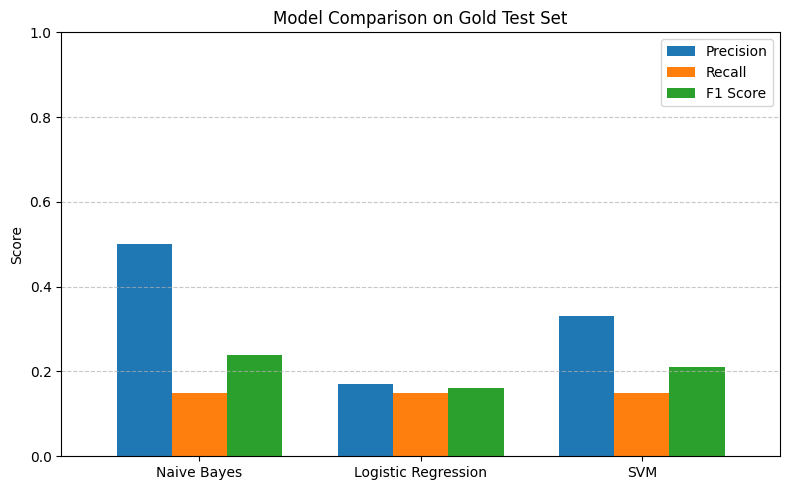

In [29]:
# Plot bar chart
comparison.set_index("Model").plot(kind="bar", figsize=(8, 5), width=0.75)

plt.title("Model Comparison on Gold Test Set")
plt.ylabel("Score")
plt.xlabel("")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

It appears that both our Logistic Regression and SVM models performed worse across the board at predicting football-related tweets compared to our Naive Bayes classifier. While all three models achieved the same level of recall (0.15), both Logistic Regression and SVM had lower precision and, in turn, lower F1 scores. These models also appeared more willing to classify a tweet in the positive class, as evidenced by the increased number of false positives. The Logistic Regression model performed the worst with 10 false positives, followed by the SVM model with 4. This may reflect their higher sensitivity in a highly imbalanced dataset, where only a small fraction of tweets were football-related.

## Conclusion

This project aimed to build a text classification model to identify football-related tweets originating from London. Starting from raw tweet data, we cleaned and preprocessed the text, created weak labels using domain-specific keywords, and held out a manually labeled gold-standard set for evaluation. We then trained and compared three classifiers: Naive Bayes, Logistic Regression, and Support Vector Machine (SVM).

Naive Bayes outperformed the other models in both precision and F1 score. However, all models struggled with recall due to the highly imbalanced dataset, with only a small number of tweets being football-related. These results highlight both the potential and the limitations of applying weak supervision and traditional models to noisy, real-world text data.

In future work, it could be useful to incorporate additional features such as timestamps, hashtags, or user mentions. These would add more context to each tweet and could help reduce class imbalance by identifying indirect signals of football relevance. Additionally, incorporating n-grams would allow the model to capture phrases and word sequences (e.g. "red card", "kick off"), rather than treating each word independently as in traditional Naive Bayes. This could improve recall by helping the model better recognise football-related patterns and reduce false negatives.